In [1]:
#import statements
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, box
import pandas as pd
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np
from matplotlib.colors import ListedColormap
from rasterio.mask import mask
import rasterio
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline


In [2]:
#Q1

counties_gdf = gpd.read_file('counties.geojson')
county_names = counties_gdf['NAME']
num_counties = len(county_names)
num_counties

72

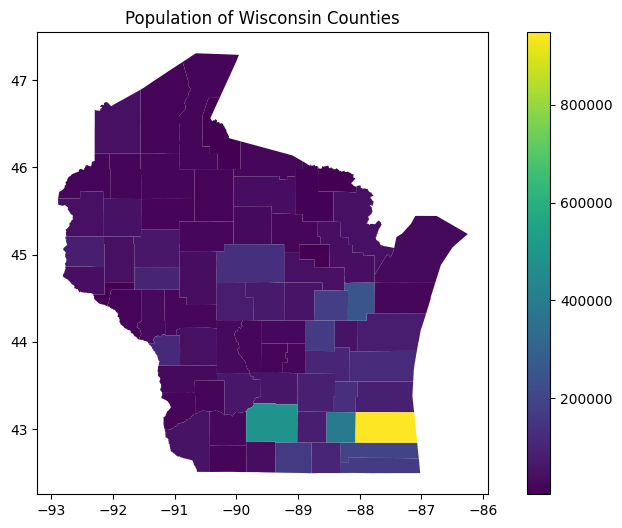

In [3]:
#Q2

# Create a geopandas plot that has a legend using the population from the POP100 column.
counties_gdf.plot(column='POP100', cmap='viridis', legend=True, figsize=(10, 6))
plt.title('Population of Wisconsin Counties')
plt.show()

In [4]:
# Feature 1

# Use sqlite to open counties_tracts.db
conn = sqlite3.connect('counties_tracts.db')
counties_df = pd.read_sql("SELECT * FROM counties", conn)
conn.close()

# Add an AREALAND column to counties_gdf
counties_gdf = counties_gdf.merge(counties_df[['NAME', 'AREALAND']])

# Split into train and test data sets
train_set, test_set = train_test_split(counties_gdf, test_size=0.25, random_state=250)

In [5]:
#Q3

# Find counties in test dataset
test_counties = test_set['NAME'].tolist()
test_counties

['Dane County',
 'Juneau County',
 'Taylor County',
 'Vilas County',
 'Rusk County',
 'Price County',
 'Jackson County',
 'Waushara County',
 'Pepin County',
 'Douglas County',
 'Ashland County',
 'Milwaukee County',
 'Waupaca County',
 'Richland County',
 'Lafayette County',
 'Washburn County',
 'Dunn County',
 'Bayfield County']

In [6]:
#Q4

X_train = train_set[['AREALAND']]
y_train = train_set['POP100']
X_test = test_set[['AREALAND']]
y_test = test_set['POP100']

model = LinearRegression()
model.fit(X_train, y_train)
test_score = model.score(X_test, y_test)
test_score

0.016720430179409274

In [7]:
#Q5

# Convert square miles to square kilometers
area_in_square_meters = 600 * 2.59 * 1_000_000

input_area_df = pd.DataFrame({'AREALAND': [area_in_square_meters]})

# Use trained model to make prediction
predicted_population = model.predict(input_area_df)

predicted_population_float = float(predicted_population[0])
predicted_population_float

78504.52061277494

In [8]:
# Feature 2

# Use sqlite to open counties_tracts.db
conn = sqlite3.connect('counties_tracts.db')

# Query to get the total housing units per county
query = """SELECT SUM(tracts.HU100) as HU100, counties.NAME
           FROM tracts
           LEFT JOIN counties ON tracts.COUNTY = counties.COUNTY
           GROUP BY counties.NAME"""

# Load data into dataframe
hu100_df = pd.read_sql(query, conn)

# Add an HU100 column to counties_gdf
counties_gdf = counties_gdf.merge(hu100_df)

# Close the connection
conn.close()

# Split updated GeoDataFrame into a train and test set
train_set, test_set = train_test_split(counties_gdf, test_size=0.25, random_state=250)



In [9]:
#Q6

#Find counties in test dataset
test_county_names = test_set['NAME'].tolist()
test_county_names

['Dane County',
 'Juneau County',
 'Taylor County',
 'Vilas County',
 'Rusk County',
 'Price County',
 'Jackson County',
 'Waushara County',
 'Pepin County',
 'Douglas County',
 'Ashland County',
 'Milwaukee County',
 'Waupaca County',
 'Richland County',
 'Lafayette County',
 'Washburn County',
 'Dunn County',
 'Bayfield County']

In [10]:
#Q7

# Find HU100 values for the counties in the test dataset
test_county_hu100 = test_set.set_index('NAME')['HU100'].to_dict()
test_county_hu100

{'Dane County': 216022,
 'Juneau County': 14669,
 'Taylor County': 10582,
 'Vilas County': 25116,
 'Rusk County': 8883,
 'Price County': 11120,
 'Jackson County': 9727,
 'Waushara County': 14843,
 'Pepin County': 3579,
 'Douglas County': 22825,
 'Ashland County': 9656,
 'Milwaukee County': 418053,
 'Waupaca County': 25396,
 'Richland County': 8868,
 'Lafayette County': 7230,
 'Washburn County': 12979,
 'Dunn County': 17964,
 'Bayfield County': 12999}

In [11]:
#Q8

hu_train = train_set[['HU100']]
pop_train = train_set['POP100']

model = LinearRegression()
cv_scores = cross_val_score(model, hu_train, pop_train)
average_score = np.mean(cv_scores)
average_score         

0.9739348181232653

In [12]:
#Q9

# Find standard deviation
sigma = cv_scores.std()
sigma


0.01693954236334351

In [13]:
#Q10

# Fit model to the dataset we are training
model.fit(hu_train, pop_train)

# Find coefficient and intercept and round to 2 decimal places
coe = round(model.coef_[0], 2)
intercept = round(model.intercept_, 2)

formula = f"POP100 = {coe}*HU100 + {intercept}"
formula



'POP100 = 2.47*HU100 + -9276.89'

Text(0, 0.5, 'POP100')

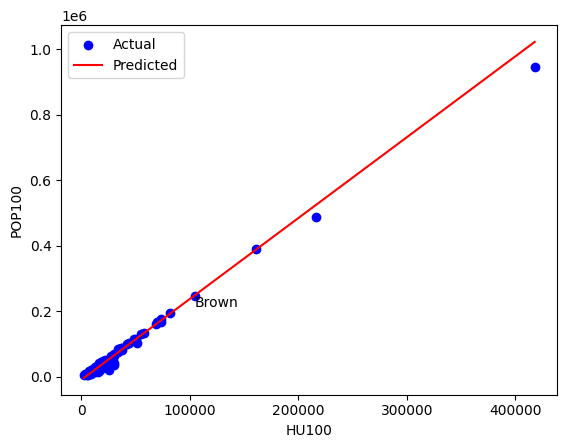

In [14]:
#Q11

hu_train = train_set[['HU100']]
pop_train = train_set['POP100']
hu_test = test_set[['HU100']]
pop_test = test_set['POP100']

model = LinearRegression()
model.fit(hu_train, pop_train)

hu100_range = pd.concat([hu_train, hu_test])
pop100_predicted = model.predict(hu100_range.sort_values(by='HU100'))

plt.figure()
plt.scatter(pd.concat([hu_train, hu_test]), pd.concat([pop_train, pop_test]), color = 'blue', label = 'Actual')
plt.plot(hu100_range.sort_values(by = 'HU100'), pop100_predicted, color = 'red', label = 'Predicted')

brown_hu100 = counties_gdf.loc[counties_gdf['NAME'] == 'Brown County', 'HU100'].iloc[0]
brown_pop100 = counties_gdf.loc[counties_gdf['NAME'] == 'Brown County', 'POP100'].iloc[0] 
plt.text(brown_hu100, brown_pop100, 'Brown', ha = 'left', va = 'top')

plt.legend()
plt.xlabel('HU100')
plt.ylabel('POP100')

In [15]:
#Q12

A = np.array([
    [0,0,5,8,4],
    [1,2,4,0,3],
    [2,4,0,9,2],
    [3,5,2,1,1],
    [0,5,0,1,0]
])

in_range_mask = (A >= 3) & (A <= 6)
in_range_mask_int = in_range_mask.astype(int)
count_in_range = in_range_mask_int.sum()
count_in_range


8

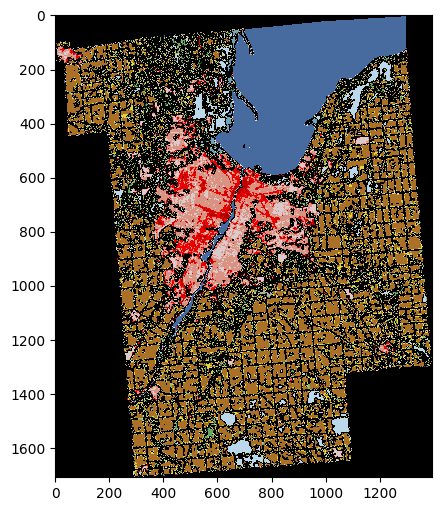

In [16]:
#Q13
c = np.zeros((256,3))
c[0] = [0.00000000000, 0.00000000000, 0.00000000000]
c[11] = [0.27843137255, 0.41960784314, 0.62745098039]
c[12] = [0.81960784314, 0.86666666667, 0.97647058824]
c[21] = [0.86666666667, 0.78823529412, 0.78823529412]
c[22] = [0.84705882353, 0.57647058824, 0.50980392157]
c[23] = [0.92941176471, 0.00000000000, 0.00000000000]
c[24] = [0.66666666667, 0.00000000000, 0.00000000000]
c[31] = [0.69803921569, 0.67843137255, 0.63921568628]
c[41] = [0.40784313726, 0.66666666667, 0.38823529412]
c[42] = [0.10980392157, 0.38823529412, 0.18823529412]
c[43] = [0.70980392157, 0.78823529412, 0.55686274510]
c[51] = [0.64705882353, 0.54901960784, 0.18823529412]
c[52] = [0.80000000000, 0.72941176471, 0.48627450980]
c[71] = [0.88627450980, 0.88627450980, 0.75686274510]
c[72] = [0.78823529412, 0.78823529412, 0.46666666667]
c[73] = [0.60000000000, 0.75686274510, 0.27843137255]
c[74] = [0.46666666667, 0.67843137255, 0.57647058824]
c[81] = [0.85882352941, 0.84705882353, 0.23921568628]
c[82] = [0.66666666667, 0.43921568628, 0.15686274510]
c[90] = [0.72941176471, 0.84705882353, 0.91764705882]
c[95] = [0.43921568628, 0.63921568628, 0.72941176471]
custom_cmap = ListedColormap(c)

land = rasterio.open("zip://land.zip")
brown_country_geom = counties_gdf[counties_gdf['NAME'] == 'Brown County'].to_crs(land.crs).geometry
matrix, _ = mask(land, brown_country_geom, crop=True)
masked_data = matrix[0]

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(masked_data, vmin=0, vmax=255, cmap=custom_cmap)


In [17]:
#Q14

land_use = {
    "open_water": 11,
    "ice_snow": 12,
    "developed_open": 21,
    "developed_low": 22,
    "developed_med": 23,
    "developed_high": 24,
    "barren": 31,
    "deciduous": 41,
    "evergreen": 42,
    "mixed_forest": 43,
    "dwarf_scrub": 51,
    "shrub_scrub": 52,
    "grassland": 71,
    "sedge": 72,
    "lichens": 73,
    "moss": 74,
    "pasture": 81,
    "crops": 82,
    "woody_wetlands": 90,
    "herbacious_wetlands": 95
}


open_water_code = land_use["open_water"]
brown_county_data = matrix[0]
total_cells = np.count_nonzero(brown_county_data)
open_water_cells = np.count_nonzero(brown_county_data == open_water_code)
open_water_portion = open_water_cells / total_cells
open_water_portion 


0.13797526789725206

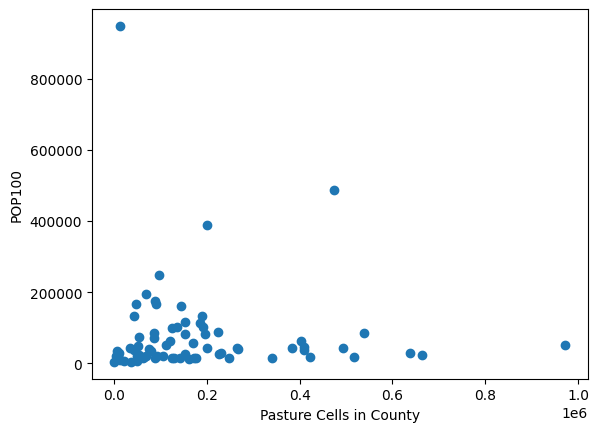

In [18]:
#Q15

land_type = "pasture"
land_type_code = land_use[land_type]

pop100_list = []
land_type_count_list = []

counties_gdf = counties_gdf.to_crs(land.crs)

for county_index in range(len(counties_gdf)):
    county = counties_gdf.iloc[county_index]
    county_geometry = [county["geometry"]]
    masked_data, _ = mask(land, county_geometry, crop=True)
    county_data = masked_data[0]
    
    land_type_count = np.count_nonzero(county_data == land_type_code)
    
    pop100_list.append(county["POP100"])
    land_type_count_list.append(land_type_count)
    
plt.scatter(land_type_count_list, pop100_list)

plt.xlabel("Pasture Cells in County")
plt.ylabel("POP100")
plt.show()
    
    

Text(0, 0.5, 'Coefficient')

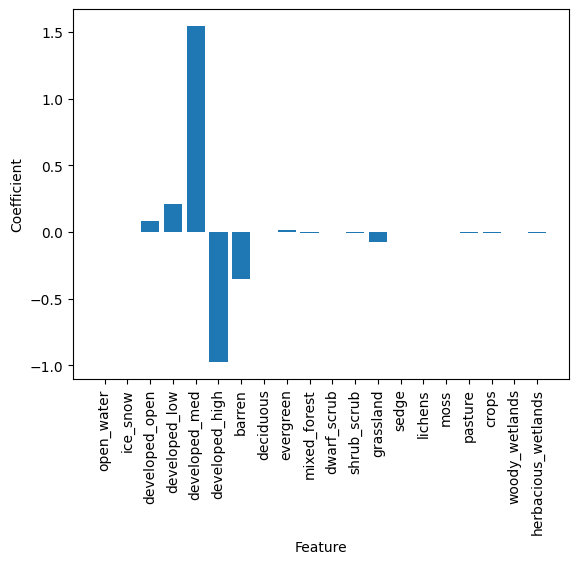

In [19]:
#Q16

tracts_gdf = gpd.read_file('tracts.shp').to_crs(land.crs)

for land_type in land_use.keys():
    tracts_gdf[land_type] = 0

for index, tract in tracts_gdf.iterrows():
    matrix, _ = mask(land, [tract['geometry']], crop = True)
    matrix = matrix[0]
    for land_type, land_code in land_use.items():
        land_count = np.count_nonzero(matrix == land_code)
        tracts_gdf.at[index, land_type] = land_count
        
X = tracts_gdf[list(land_use.keys())]
y = tracts_gdf['POP100']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=300)
model = LinearRegression()
model.fit(X_train, y_train)
coefs = model.coef_
plt.bar(X.columns, coefs)
plt.xticks(rotation = 90)
plt.xlabel('Feature')
plt.ylabel('Coefficient')


# The graph shows the coefficients of each feature (land type) in the trained Linear Regression model for predicting POP100
# A positive correlation coefficient could indicate that an increase in population count, while a negative coefficient suggests a decrease in population count
# Looking at the correlation coefficient of the data could help interpret the importance of different land types that influence population distribution


In [20]:
#Q17

first_model = LinearRegression()
pipeline = [('lasso', Lasso())]
second_model = Pipeline(steps = pipeline)
x = tracts_gdf[list(land_use.keys())]
y = tracts_gdf['POP100']

scores_first_model = cross_val_score(first_model, x, y, cv = 5)
scores_second_model = cross_val_score(second_model, x, y, cv = 5)


first_mean_score = scores_first_model.mean()
first_variance_score = scores_first_model.var()
second_mean_score = scores_second_model.mean()
second_variance_score = scores_second_model.var()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 300)

rec_model = first_model if first_mean_score > second_mean_score else second_model
rec_model.fit(x_train, y_train)
test_score = rec_model.score(x_test, y_test)
test_score

# The type of model I would recommend is a Lasso model.
# Although both of these models haver very low variance of cross validation scores, the mean cross-validation scores are high.
# The Lasso Regression model alsop tends to produce sparse models and force some of the coefficients to be exactly zero.
# This helps improve generatlization performance, especially with datasets that have correlated features. 


0.4893472971813668